In [1]:
%cd ../..

/home/nialov/projects/fractopo


In [35]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import geopandas as gpd
from scipy import stats

from fractopo import Network
import tests
import powerlaw
from fractopo.analysis import length_distributions
from tests import Helpers

In [3]:
distributions = tests.test_fit_to_multi_scale_lengths_params()[0]
aland_200k_traces = gpd.read_file(
    "/mnt/c/data/tracerepository/tracerepository_data/ahvenanmaa/traces/200000/ahvenanmaa_integrated_lineaments_1_200000_traces.geojson"
)
aland_200k_area = gpd.read_file(
    "/mnt/c/data/tracerepository/tracerepository_data/ahvenanmaa/area/200000/ahvenanmaa_integrated_lineaments_1_200000_area.geojson"
)

aland_20k_traces = gpd.read_file(
    "/mnt/c/data/tracerepository/tracerepository_data/ahvenanmaa/traces/infinity/geta_lidar_lineaments_infinity_traces.geojson"
)
aland_20k_area = gpd.read_file(
    "/mnt/c/data/tracerepository/tracerepository_data/ahvenanmaa/area/infinity/geta_lidar_lineaments_infinity_area.geojson"
)

geta_20m_traces = gpd.read_file(
    "/home/nialov/projects/ahvenanmaa-scalability-article/ahvenanmaa-scalability-analysis/outputs/networks/concatenated/scale_20m_traces.geojson"
)
geta_20m_area = gpd.read_file(
    "/home/nialov/projects/ahvenanmaa-scalability-article/ahvenanmaa-scalability-analysis/outputs/networks/concatenated/scale_20m_area.geojson"
)

traces = (geta_20m_traces, aland_20k_traces, aland_200k_traces)
areas = (geta_20m_area, aland_20k_area, aland_200k_area)
names = "20m", "20k", "200k"

networks = [
    Network(
        trace_gdf=tgdf,
        area_gdf=agdf,
        name=n_name,
        determine_branches_nodes=True,
        circular_target_area=True,
        truncate_traces=True,
    )
    for tgdf, agdf, n_name in zip(traces, areas, names)
]

[3.48727376e+01 1.13185338e+04 5.64028567e+04]


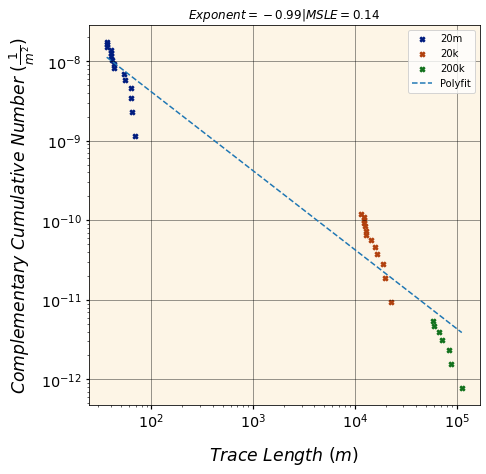

In [4]:
distributions = [
    length_distributions.LengthDistribution(
        lengths=netw.trace_length_array, name=netw.name, area_value=netw.total_area
    )
    for netw in networks
]

mld = length_distributions.MultiLengthDistribution(
    distributions=distributions,
    using_branches=False,
    fitter=length_distributions.scikit_linear_regression,
)

shgo_kwargs = dict(sampling_method="sobol", iters=100, n=2**6)

opt_result, opt_mld = mld.optimize_cut_offs()

polyfit, fig, ax = opt_mld.plot_multi_length_distributions(automatic_cut_offs=False)

assert isinstance(opt_result, length_distributions.MultiScaleOptimizationResult)
assert isinstance(polyfit, length_distributions.Polyfit)
assert isinstance(fig, Figure) and isinstance(ax, Axes)

for cut_off in opt_result.optimize_result.xl:
    print(cut_off)

In [5]:
opt_result.polyfit.msle

0.1435295670723199

In [6]:
opt_mld.cut_offs

[34.872737610739264, 11318.53380950466, 56402.85671769613]

In [7]:
ls, ccms = opt_mld.normalized_distributions(automatic_cut_offs=False)

In [8]:
lengths, ccm = np.concatenate(ls), np.concatenate(ccms)

In [9]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_log_error,
    mean_squared_error,
    r2_score,
)

In [10]:
print(len(ccm), len(opt_result.polyfit.y_fit))
for metric in (
    mean_absolute_error,
    mean_squared_log_error,
    mean_squared_error,
    r2_score,
):
    print(metric.__name__)
    print(metric(ccm, opt_result.polyfit.y_fit))

35 35
mean_absolute_error
1.1834844813542645e-09
mean_squared_log_error
4.564804899197045e-18
mean_squared_error
4.564804993264777e-18
r2_score
0.8564704329276801


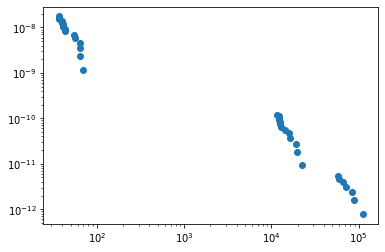

In [34]:
plt.scatter(lengths, ccm)
plt.xscale("log")
plt.yscale("log")

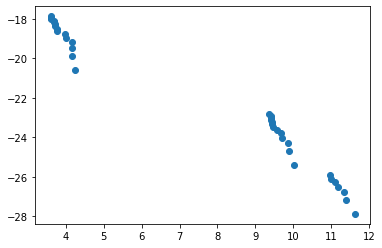

In [45]:
plt.scatter(np.log(lengths), np.log(ccm))

In [48]:
fit = powerlaw.Fit(lengths, xmin=1e-8)

In [58]:
fit.fitting_cdf, fit.fitting_cdf_bins

(array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
        0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
        0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
        0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
        0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
        0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
        0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857]),
 array([3.63570852e+01, 3.66430536e+01, 3.67464639e+01, 3.98069266e+01,
        4.02292963e+01, 4.05174951e+01, 4.10198388e+01, 4.32362849e+01,
        4.33812422e+01, 5.39375958e+01, 5.53804874e+01, 6.35692675e+01,
        6.36607991e+01, 6.40921740e+01, 6.97288771e+01, 1.15532451e+04,
        1.22615284e+04, 1.23231189e+04, 1.23589595e+04, 1.26315199e+04,
        1.27429207e+04, 1.29067080e+04, 1.45239131e+04, 1.59034677e+04,
        1.65153620e+04, 1.89529327e+04, 1.97968607e+04, 2.25795417e+04,
        5.87300045

In [57]:
np.array(list(reversed(ccm)))

array([7.82617320e-13, 1.56523464e-12, 2.34785196e-12, 3.13046928e-12,
       3.91308660e-12, 4.69570392e-12, 5.47832124e-12, 9.30519942e-12,
       1.86103988e-11, 2.79155983e-11, 3.72207977e-11, 4.65259971e-11,
       5.58311965e-11, 6.51363959e-11, 7.44415953e-11, 8.37467948e-11,
       9.30519942e-11, 1.02357194e-10, 1.11662393e-10, 1.20967592e-10,
       1.16264388e-09, 2.32528777e-09, 3.48793165e-09, 4.65057554e-09,
       5.81321942e-09, 6.97586331e-09, 8.13850719e-09, 9.30115107e-09,
       1.04637950e-08, 1.16264388e-08, 1.27890827e-08, 1.39517266e-08,
       1.51143705e-08, 1.62770144e-08, 1.74396583e-08])

Fit: (3.0714273498571396, -0.00011768673315876781, 1.0182160883312272)
ks : KstestResult(statistic=0.05125972098247822, pvalue=0.010071237087691054)


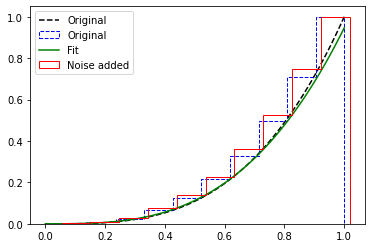

In [61]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


# Exponent
a = 3.2

# Number of samples
n_samples = 1000


# Generate powerlaw data
data = scipy.stats.powerlaw.rvs(a, loc=0, scale=1, size=n_samples)

# Introduce some gaussian noise
data_noise = data + np.random.normal(0, 0.01, size=n_samples)


### Fit a powerlaw to given data

# Initial estimate of the exponent
exp_est = 3.0

# Initial estimate of x0
x0_est = 0

# Initial estimate of the scale
scale_est = 1


# Perform the fit
pl_fit = scipy.stats.powerlaw.fit(data_noise, exp_est, loc=x0_est, scale=scale_est)


print("Fit:", pl_fit)
###


x_arr = np.linspace(0, 1, 100)

# Plot CDF of the original
plt.plot(
    x_arr,
    scipy.stats.powerlaw.cdf(x_arr, a),
    color="k",
    linestyle="--",
    label="Original",
)
plt.hist(
    data,
    cumulative=1,
    histtype="step",
    color="b",
    linestyle="--",
    label="Original",
    density=True,
)

# Plot CDF of the noisy data and the fit
plt.plot(x_arr, scipy.stats.powerlaw.cdf(x_arr, *pl_fit), color="g", label="Fit")
plt.hist(
    data_noise,
    cumulative=1,
    histtype="step",
    color="r",
    label="Noise added",
    density=True,
)

ks = stats.ks_1samp(data_noise, stats.powerlaw.cdf, args=(*pl_fit,))
stats.powerlaw.cdf

print(f"ks : {ks}")

plt.legend()

plt.show()

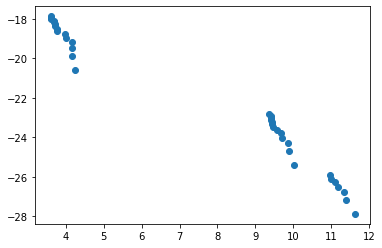

In [59]:
plt.scatter(np.log(lengths), np.log(ccm))